In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import geemap,ee
import matplotlib.colors as colors
from shapely.geometry import shape, box
from matplotlib import colors
import matplotlib.patches as mpatches


# Extracción de Series de Tiempo en GEE y xarray.


En este ejercicio demostraremos cómo extraer series de tiempo para una determinada ubicación geográfica, o para una región de interés, utilizando distintos métodos disponibles en las librerías `geemap`y `xarray`.<br>.

La pregunta que buscamos responder es, **¿cómo han evolucionado las temperaturas diarias en las distintas comunas de la región metropolitana de Chile en las últimas 4 décadas?** Para realizar un buen análisis, necesitamos extraer primero los datos de temperatura para todo este período.


## 1. Dataset.

Utilizaremos el dataset de temperaturas diarias ERA5, disponible en GEE. Este dataset tiene cobertura global, con una resolución espacial de aproximadamente 30 km.

<div class="alert alert-block alert-info">
<b>Descripción:</b> 

ERA5 Daily Aggregates: https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_DAILY

ERA5 is the fifth generation ECMWF atmospheric reanalysis of the global climate. Reanalysis combines model data with observations from across the world into a globally complete and consistent dataset. ERA5 replaces its predecessor, the ERA-Interim reanalysis.

ERA5 DAILY provides aggregated values for each day for seven ERA5 climate reanalysis parameters: 2m air temperature, 2m dewpoint temperature, total precipitation, mean sea level pressure, surface pressure, 10m u-component of wind and 10m v-component of wind. Additionally, daily minimum and maximum air temperature at 2m has been calculated based on the hourly 2m air temperature data. Daily total precipitation values are given as daily sums. All other parameters are provided as daily averages.

ERA5 data is available from 1979 to three months from real-time. More information and more ERA5 atmospheric parameters can be found at the Copernicus Climate Data Store.
</div>

En este caso, utilizaremos como variable de análisis la temperatura del aire medida a 2m de altura (`mean_2m_air_temperature`).

In [3]:
#Inicializamos GEE
ee.Authenticate()

True

In [4]:
ee.Initialize(project='ee-erickbarrios3') #use su código de proyecto

In [5]:
#Definimos el período de análisis
time =["1981-01-01", "2021-12-01"]

Como insumo, tenemos los límites de la RM y de sus comunas en formato GeoJSON:

In [6]:
r13=gpd.read_file('R13.geojson')
comunas=gpd.read_file('comunas.geojson')
comunas.head()

id  OBJECTID  ID           COMUNA  \
0  comunas_1.1         1   1            ALHUE   
1  comunas_1.2         2   2             BUIN   
2  comunas_1.3         3   3  CALERA DE TANGO   
3  comunas_1.4        14  14    ISLA DE MAIPO   
4  comunas_1.5         4   4        CERRILLOS   

                             REGION            Ha            LAYER  \
0  REGION METROPOLITANA DE SANTIAGO  84367.121194            ALHUE   
1  REGION METROPOLITANA DE SANTIAGO  21586.998175             BUIN   
2  REGION METROPOLITANA DE SANTIAGO   7234.810464  CALERA DE TANGO   
3  REGION METROPOLITANA DE SANTIAGO  18712.733064    ISLA DE MAIPO   
4  REGION METROPOLITANA DE SANTIAGO   1682.860880        CERRILLOS   

         COORD_X       COORD_Y     Shape_Leng    Shape_Area  \
0  310338.621634  6.231572e+06  156471.774880  8.436590e+08   
1  339166.792747  6.264813e+06   88821.564212  2.158670e+08   
2  334135.737685  6.278631e+06   44603.526367  7.234713e+07   
3  320010.622917  6.264362e+06   79845.510004  1.871247e+08   
4  341122.588117  6.292402e+06   20888.209684  1.682839e+07   

                                            geometry  
0  POLYGON ((-71.26993 -34.05348, -71.28266 -34.0...  
1  POLYGON ((-70.82377 -33.75548, -70.81756 -33.7...  
2  POLYGON ((-70.82423 -33.60983, -70.81907 -33.5...  
3  POLYGON ((-71.02326 -33.71436, -71.0146 -33.71...  
4  POLYGON ((-70.73691 -33.50373, -70.73123 -33.4...

In [12]:
comunas['COMUNA'].value_counts()

COMUNA
ALHUE                1
BUIN                 1
CALERA DE TANGO      1
ISLA DE MAIPO        1
CERRILLOS            1
LA CISTERNA          1
LA FLORIDA           1
CERRO NAVIA          1
COLINA               1
CONCHALI             1
CURACAVI             1
EL BOSQUE            1
LA GRANJA            1
SAN MIGUEL           1
SAN PEDRO            1
EL MONTE             1
LO ESPEJO            1
ESTACION CENTRAL     1
HUECHURABA           1
INDEPENDENCIA        1
LA PINTANA           1
LO PRADO             1
LA REINA             1
LAMPA                1
LAS CONDES           1
LO BARNECHEA         1
MACUL                1
MAIPU                1
MARIA PINTO          1
MELIPILLA            1
NUNOA                1
PAC                  1
PENAFLOR             1
PENALOLEN            1
PIRQUE               1
PADRE HURTADO        1
PAINE                1
PROVIDENCIA          1
PUDAHUEL             1
PUENTE ALTO          1
QUINTA NORMAL        1
QUILICURA            1
RECOLETA             1
RENC

## 2. Cálculo de estadísticas de temperaturas en GEE.

En GEE, una capa vectorial (es decir, un conjunto de objetos geométricos con diversos atributos numéricos y/o cualitativos) corresponde a una collección de `Features` o `FeatureCollection`.

<div class="alert alert-block alert-info">
<b></b> 
    
*A Feature in Earth Engine is defined as a GeoJSON Feature. Specifically, a Feature is an object with a geometry property storing a Geometry object (or null) and a properties property storing a dictionary of other properties.*<br>
Para mayor información, ver: https://developers.google.com/earth-engine/guides/features<br>
</div>

Para trabajar con polígonos en GEE (por jemplo, para calcular estadísticas zonales sobre una imagen o secuencia de imágenes), debemos crear por lo tanto una `FeatureCollection`. <br>
Para ello utilizamos funciones implementadas en `geemap`: https://book.geemap.org/chapters/04_local_data.html#

In [7]:
fc_region = geemap.geopandas_to_ee(r13)  #feature collection
fc_com= geemap.geopandas_to_ee(comunas)  #feature collection

In [8]:
fc_region

In [9]:
fc_com

### Colección de imágenes:

In [34]:
#Filtramos la colección para las fechas y region de interés
era5_2mt = (ee.ImageCollection('ECMWF/ERA5/DAILY').filterBounds(fc_region).select('mean_2m_air_temperature').filter(ee.Filter.date(time[0],time[1])))

Como ejemplo, visualizaremos la primera imagen de la colección filtrada:

In [35]:
# Visualization palette for temperature (mean, min and max) and 2m dewpoint
# https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_DAILY

#Recordar: las temperaturas están en unidades de grados Kelvin (ver descripción del dataset en GEE)
vis_2mt = {'min': 250,'max': 320,
    'palette': ['000080','0000d9','4000ff','8000ff','0080ff','00ffff','00ff80','80ff00','daff00','ffff00','fff500','ffda00','ffb000','ffa400','ff4f00','ff2500','ff0a00','ff00ff',]}

lat=r13.centroid.y[0]
lon=r13.centroid.x[0]
m = geemap.Map(center=[lat,lon], zoom=8)

#Mapa completo para todo el planeta (sin clip)
#m.add_layer(era5_2mt.first(),vis_2mt,'Daily mean 2m air temperature',)

m.add_layer(era5_2mt.first().clip(fc_region),vis_2mt,'Daily mean 2m air temperature',)
m

Map(center=[-33.604345423843746, -70.62709609217843], controls=(WidgetControl(options=['position', 'transparen…

### 2.1 Cálculo de estadísticas zonales para una imagen.

Veamos ahora cómo obtener las temperaturas promedio para una región o comuna, tanto para una imagen como para una serie temporal de imágenes.

#### 2.1.1 Una imagen, una geometría.
Usamos `reduceRegion` para obtener estadísticas para una única geometría (por ejemplo, el polígono de la RM): https://developers.google.com/earth-engine/apidocs/ee-image-reduceregion

In [36]:
image=era5_2mt.first() #seleccionamos la primera imagen de la lista, como ejemplo.

#Valor promedio de la temperatura para RM, calculada para la primera imagen de la colección
#Si queremos obtener otra estad{istica (por ejemplo, la mediana, min, max, std), hay que cambiar el argumento "reducer".
zone_stats = image.reduceRegion(geometry=fc_region, reducer=ee.Reducer.mean()).getInfo()

#El resultado es un diccionario. En este caso, contiene sólo un valor como resultado (la temperatura promedio en la RM, para la primera fecha seleccionada)
zone_stats.keys()

dict_keys(['mean_2m_air_temperature'])

La temperatura promedio en la RM, para la primera fecha seleccionada

In [37]:
zone_stats['mean_2m_air_temperature']

285.96064498896357

#### 2.1.2 Una imagen, una colección de geometrías.

Ahora obtendremos la temperatura promedio *para cada comuna*, para la primera fecha seleccionada.

Usamos `reduceRegions` para obtener estadísticas para un **conjunto de geometrías** (por ejemplo, las comunas de la RM): https://developers.google.com/earth-engine/apidocs/ee-image-reduceregions
* Note que no es la misma función anterior, tiene el mismo nombre pero en plural.

In [38]:
image=era5_2mt.first() #seleccionamos la primera imagen de la lista, como ejemplo.

#Valor promedio de la temperatura para cada comuna, calculada para la primera imagen de la colección
com_stats = image.reduceRegions(collection=fc_com, reducer=ee.Reducer.mean()).getInfo()

#El resultado es una lista 3 diccionarios: dict_keys(['type', 'columns', 'features'])
len(com_stats)

3

In [39]:
com_stats.keys()

dict_keys(['type', 'columns', 'features'])

In [40]:
com_stats['columns'] #columnas del GeoJSON

{'COMUNA': 'String',
 'T_mean': 'Float',
 'mean': 'Float',
 'system:index': 'String'}

In [41]:
len(com_stats['features']) #52 comunas

52

In [42]:
com_stats['features'][0]['properties'] #datos para la primera comuna

{'COMUNA': 'ALHUE', 'T_mean': 290.88329707090617, 'mean': 290.88329707090617}

#### ¿Cómo ordenamos las estadísticas para cada comuna?<br>

**Idea 1**: iterar sobre cada diccionario => ¡Evitemos los loops!<br>
**Idea 2**: usar `pandas.json_normalize` para convertir un objeto JSON a DataFrame.

In [43]:
#Idea 1: Ud. NO lo haga!
for i in range(len(com_stats['features'])):
    com_stats['features'][i].keys()
    T=com_stats['features'][i]['properties']['mean'] #La temperatura promedio
    name=com_stats['features'][i]['properties']['COMUNA']
    print(name,T)

ALHUE 290.88329707090617
BUIN 291.5850165230887
CALERA DE TANGO 291.50355792867725
ISLA DE MAIPO 291.27915527343754
CERRILLOS 291.35858590262274
LA CISTERNA 291.8945617675781
LA FLORIDA 291.15941946847096
CERRO NAVIA 291.283695765904
COLINA 290.12253194119495
CONCHALI 291.1441955566406
CURACAVI 290.65008777120835
EL BOSQUE 291.8945617675781
LA GRANJA 291.8945617675781
SAN MIGUEL 291.5193786621094
SAN PEDRO 291.0073158779328
EL MONTE 291.1044988217561
LO ESPEJO 291.8945617675781
ESTACION CENTRAL 291.1441955566406
HUECHURABA 291.1441955566406
INDEPENDENCIA 291.1441955566406
LA PINTANA 291.8945617675781
LO PRADO 291.1441955566406
LA REINA 290.5904052734375
LAMPA 291.34795736853096
LAS CONDES 288.375244140625
LO BARNECHEA 284.8579848716999
MACUL 291.1441955566406
MAIPU 291.4998075045072
MARIA PINTO 290.2904314052559
MELIPILLA 290.91654388485426
NUNOA 291.1441955566406
PAC 291.1441955566406
PENAFLOR 291.4895935058594
PENALOLEN 288.86388262580425
PIRQUE 289.0764125477184
PADRE HURTADO 291.48

In [ ]:
#Idea 2: Esto sí!
df=pd.json_normalize(com_stats['features'],max_level=1)
df= df[['properties.COMUNA','properties.mean']] #nos quedamos sólo con las columnas de interés
df.head()

properties.COMUNA  properties.mean
0             ALHUE       290.883297
1              BUIN       291.585017
2   CALERA DE TANGO       291.503558
3     ISLA DE MAIPO       291.279155
4         CERRILLOS       291.358586

In [45]:
#agregamos el dato de Tmean al geodataframe inicial de comunas, para graficarlo
comunas=comunas[['COMUNA','geometry']].merge(df,left_on='COMUNA',right_on='properties.COMUNA',how='left')
comunas.drop(columns='properties.COMUNA',inplace=True)
comunas.rename(columns={'properties.mean':'T_mean'},inplace=True)

comunas.head()

COMUNA                                           geometry  \
0            ALHUE  POLYGON ((-71.26993 -34.05348, -71.28266 -34.0...   
1             BUIN  POLYGON ((-70.82377 -33.75548, -70.81756 -33.7...   
2  CALERA DE TANGO  POLYGON ((-70.82423 -33.60983, -70.81907 -33.5...   
3    ISLA DE MAIPO  POLYGON ((-71.02326 -33.71436, -71.01460 -33.7...   
4        CERRILLOS  POLYGON ((-70.73691 -33.50373, -70.73123 -33.4...   

       T_mean  
0  290.883297  
1  291.585017  
2  291.503558  
3  291.279155  
4  291.358586

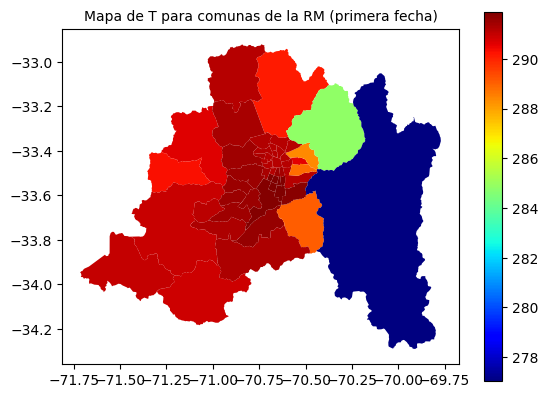

In [46]:
ax=comunas.plot(column='T_mean',cmap='jet',legend=True);
ax.set_title('Mapa de T para comunas de la RM (primera fecha)',fontsize=10);

### Ahora, ¿cómo lo hacemos para toda la secuencia de imágenes?

Recordemos que queremos obtener la serie de tiempo de la T promedio para cada comuna de la RM.


In [47]:
#Resumimos los pasos anteriores en una función
def image_region_stats(img,collection=fc_com,reducer=ee.Reducer.mean()):

    com_stats = img.reduceRegions(collection=collection, reducer=reducer).getInfo()
    df=pd.json_normalize(com_stats['features'],max_level=1)
    date=ee.Date(img.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    df['date']=date

    df=df[['date','properties.COMUNA','properties.mean']]

    return (df)


In [48]:
#Aplicamos la función sobre la primera imagen de la colección. Para reducir cálculos, primero recortamos la imagen a la región de interés (RM)
image=image.clip(fc_region)
df=image_region_stats(image,fc_com)  #lento!!
df

date  properties.COMUNA  properties.mean
0   1981-01-01              ALHUE       290.883297
1   1981-01-01               BUIN       291.585017
2   1981-01-01    CALERA DE TANGO       291.503558
3   1981-01-01      ISLA DE MAIPO       291.279155
4   1981-01-01          CERRILLOS       291.358586
5   1981-01-01        LA CISTERNA       291.894562
6   1981-01-01         LA FLORIDA       291.159419
7   1981-01-01        CERRO NAVIA       291.283696
8   1981-01-01             COLINA       290.122532
9   1981-01-01           CONCHALI       291.144196
10  1981-01-01           CURACAVI       290.650088
11  1981-01-01          EL BOSQUE       291.894562
12  1981-01-01          LA GRANJA       291.894562
13  1981-01-01         SAN MIGUEL       291.519379
14  1981-01-01          SAN PEDRO       291.007316
15  1981-01-01           EL MONTE       291.104499
16  1981-01-01          LO ESPEJO       291.894562
17  1981-01-01   ESTACION CENTRAL       291.144196
18  1981-01-01         HUECHURABA       291.144196
19  1981-01-01      INDEPENDENCIA       291.144196
20  1981-01-01         LA PINTANA       291.894562
21  1981-01-01           LO PRADO       291.144196
22  1981-01-01           LA REINA       290.590405
23  1981-01-01              LAMPA       291.347957
24  1981-01-01         LAS CONDES       288.375244
25  1981-01-01       LO BARNECHEA       284.857985
26  1981-01-01              MACUL       291.144196
27  1981-01-01              MAIPU       291.499808
28  1981-01-01        MARIA PINTO       290.290431
29  1981-01-01          MELIPILLA       290.916544
30  1981-01-01              NUNOA       291.144196
31  1981-01-01                PAC       291.144196
32  1981-01-01           PENAFLOR       291.489594
33  1981-01-01          PENALOLEN       288.863883
34  1981-01-01             PIRQUE       289.076413
35  1981-01-01      PADRE HURTADO       291.489594
36  1981-01-01              PAINE       291.280934
37  1981-01-01        PROVIDENCIA       291.144196
38  1981-01-01           PUDAHUEL       291.465356
39  1981-01-01        PUENTE ALTO       291.759141
40  1981-01-01      QUINTA NORMAL       291.144196
41  1981-01-01          QUILICURA       291.221696
42  1981-01-01           RECOLETA       291.144196
43  1981-01-01              RENCA       291.225571
44  1981-01-01       SAN BERNARDO       291.794979
45  1981-01-01        SAN JOAQUIN       291.394318
46  1981-01-01  SAN JOSE DE MAIPO       277.022932
47  1981-01-01          SAN RAMON       291.894562
48  1981-01-01           SANTIAGO       291.144196
49  1981-01-01          TALAGANTE       291.480309
50  1981-01-01             TILTIL       291.141461
51  1981-01-01           VITACURA       291.144196

In [49]:
#Tenemos ~14000 fechas en total. Repetir eso para cada fecha es muy lento.
print(era5_2mt.size().getInfo())

14435


Para realizar cómputos masivos como éste, GEE implementa operaciones `map`y `reduce`que están optimizadas para computación paralela, pero hacen un poco más compleja la programación. Como alternativa en este caso, podemos utilizar también las capacidades de `xarray`, que puede simplificas enormemente la extracción de series de tiempo.

## 3. Cálculo de estadísticas de temperatura con `xarray`

### 3.1 Exportar colección a `xarray`.

Primero exportaremos la colección a un Dataset de `xarray`, usando la librería `geemap`:

#### Dataset:

In [50]:
ds = geemap.ee_to_xarray(era5_2mt, crs="EPSG:4326",scale=0.25)
ds.rio.set_spatial_dims("lon", "lat", inplace=True) #por si acaso, declarar las dimensiones espaciales
ds

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.1/472.1 kB 1.2 MB/s eta 0:00:00
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.4/207.4 kB 568.4 kB/s eta 0:00:00
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 1.4 MB/s eta 0:00:00
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.6 MB/s eta 0:00:00
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 3.3 MB/s eta 0:00:00
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.0 MB/s eta 0:00:00
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.6/268.6 kB 5.9 MB/s eta 0:00:00
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 234.5 kB/s eta 0:00:00
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.8/430.8 kB 5.6 MB/s eta 0:00:00
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.4 MB/s eta 0:00:00
Attempting uninstall: contourpy
Found existing installation: contourpy 1.1.0
Uninstalling contourpy-1.1.0:
Successfully uninstalled contourpy-1.1.0
Attempting uninstall: earthengine-api
Found existing installation: earthengine-api 1.6.6
Uninstal


[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


<xarray.Dataset> Size: 60GB
Dimensions:                  (time: 14435, lon: 1440, lat: 720)
Coordinates:
  * time                     (time) datetime64[ns] 115kB 1981-01-01 ... 2020-...
  * lon                      (lon) float64 12kB -179.9 -179.6 ... 179.6 179.9
  * lat                      (lat) float64 6kB -89.88 -89.62 ... 89.62 89.88
Data variables:
    mean_2m_air_temperature  (time, lon, lat) float32 60GB ...
Attributes: (12/36)
    date_range:               [284083200000, 1594252800000]
    description:              <p>ERA5 is the fifth generation ECMWF atmospher...
    keywords:                 ['climate', 'copernicus', 'dewpoint', 'ecmwf', ...
    max_mirrored_version:     1594797432309553
    period:                   1
    period_mapping:           [284083200000, 1594252800000]
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     Daily mean u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

<div class="alert alert-block alert-info">
<b>Nota:</b> 
Por algún motivo, la función geemap.ee_to_xarray() no reconoce cuando una colección ha sido recortada a una determinada región usando .clip(aoi), sino que siempre exporta la imagen completa. Esto hace más lenta la exportación, y puede generar problemas con datasets de mayor resolución espacial y tamaño. 
</div>

In [51]:
ds['time']

<xarray.DataArray 'time' (time: 14435)> Size: 115kB
array(['1981-01-01T00:00:00.000000000', '1981-01-02T00:00:00.000000000',
       '1981-01-03T00:00:00.000000000', ..., '2020-07-07T00:00:00.000000000',
       '2020-07-08T00:00:00.000000000', '2020-07-09T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 115kB 1981-01-01 1981-01-02 ... 2020-07-09

In [52]:
print(ds.attrs.keys())

dict_keys(['date_range', 'description', 'keywords', 'max_mirrored_version', 'period', 'period_mapping', 'product_tags', 'provider', 'provider_url', 'sample', 'source_tags', 'tags', 'thumb', 'title', 'type_name', 'visualization_0_bands', 'visualization_0_max', 'visualization_0_min', 'visualization_0_name', 'visualization_0_palette', 'visualization_1_bands', 'visualization_1_max', 'visualization_1_min', 'visualization_1_name', 'visualization_1_palette', 'visualization_2_bands', 'visualization_2_max', 'visualization_2_min', 'visualization_2_name', 'visualization_2_palette', 'visualization_3_bands', 'visualization_3_max', 'visualization_3_min', 'visualization_3_name', 'visualization_3_palette', 'crs'])


#### DataArray:

Si seleccionamos la variable `mean_2m_air_temperature` , generamos un DataArray:

In [53]:
da=ds.sel(time='1991-01-01')['mean_2m_air_temperature']
da

<xarray.DataArray 'mean_2m_air_temperature' (lon: 1440, lat: 720)> Size: 4MB
[1036800 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 1991-01-01
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
Attributes:
    id:             mean_2m_air_temperature
    data_type:      {'type': 'PixelType', 'precision': 'float'}
    dimensions:     [1440, 721]
    crs:            EPSG:4326
    crs_transform:  [0.25, 0, -180, 0, -0.25, 90]

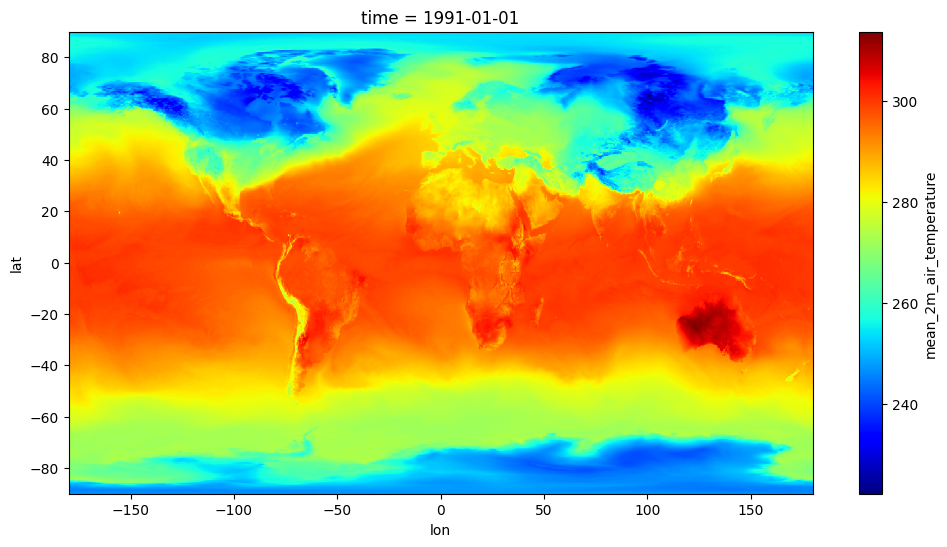

In [56]:
da.plot(x='lon',y='lat',cmap='jet',figsize=(12,6))
plt.show()

### 3.2 Obtener la serie de tiempo para una posición determinada.

Del DataSet, seleccionamos datos para una ubicación (lon,lat) determinada. Si las coordenadas entregadas no coinciden exactamente con el centro de un pixel, se interpola para encontar el pixel más cercano, por lo cual es necesario especificar el método `nearest` (vea qué sucede al quitar este argumento).

In [55]:
ts=ds['mean_2m_air_temperature'].sel(lon=-72.44,lat=-33.67,method='nearest')
ts

<xarray.DataArray 'mean_2m_air_temperature' (time: 14435)> Size: 58kB
[14435 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 115kB 1981-01-01 1981-01-02 ... 2020-07-09
    lon      float64 8B -72.38
    lat      float64 8B -33.62
Attributes:
    id:             mean_2m_air_temperature
    data_type:      {'type': 'PixelType', 'precision': 'float'}
    dimensions:     [1440, 721]
    crs:            EPSG:4326
    crs_transform:  [0.25, 0, -180, 0, -0.25, 90]

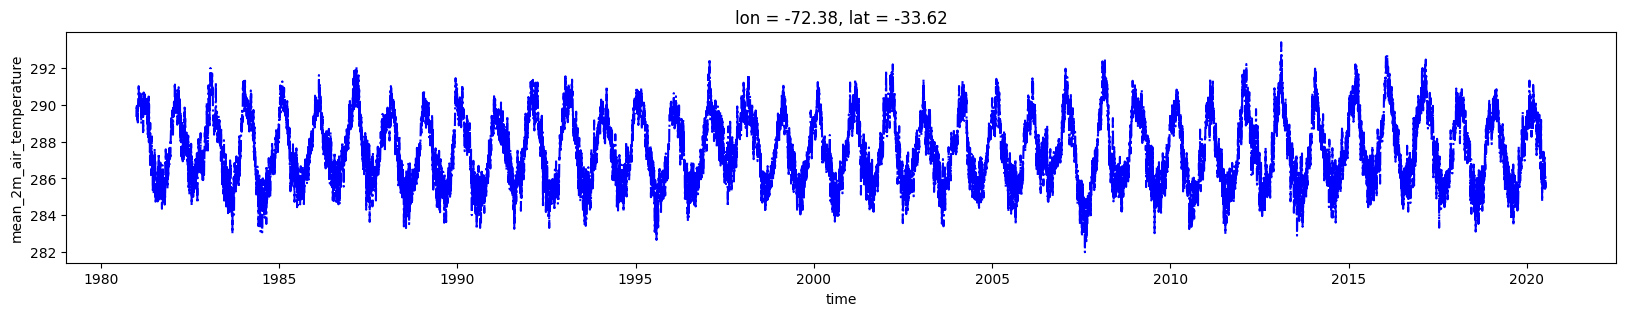

In [57]:
#Graficamos la serie de tiempo.
fig,ax=plt.subplots(1,1,figsize=(20,3))
ts.plot.line("b-.",ax=ax);

### 3.3 Recortar una imagen o dataset con una geometría.

Ahora, queremos obtener una serie de tiempo como la anterior, pero no para una ubicación única, sino que para la comuna completa. Es decir, nos interesa: 
* recordar el dataset a la forma de cada comuna
* para cada fecha, calcular el promedio de la temperatura sobre todos los pixeles que comprenden dicha comuna
* graficar la serie de tiempo.

Para el primer paso, podríamos usar la función `clip`, por ejemplo: `clip_region = ds.rio.clip(r13.geometry.values, r13.crs, drop=True)` <br>
Como referencia para esta operación, vea la documentación de `rioxarray`: https://corteva.github.io/rioxarray/stable/examples/clip_geom.html

<div class="alert alert-block alert-info">
<b>Nota:</b> 
Al menos en el sistema de la profesora, esta operación no funciona al aplicarla sobre el dataset creado con geemap_to_xarray(). Puede probar ud. mismo, ¿obtiene un error?

Pero, hay un workaround: 
* recortar la colección a un rectángulo (box) usando la función clip_box (esta sí funciona correctamente).
* exportar al disco local (en formato nc, por ejemplo)
* luego volver a leer el dataset. Este dataset reducido sí puede ser recortado correctamente con una geometría o geodataframe. 
* esto es probablemente un bug de geemap.

</div>

In [58]:
clip_box= ds.rio.clip_box(minx=-73,miny=-36,maxx=-68,maxy=-30,crs="EPSG:4326",) #este recorte sí funciona

In [59]:
clip_box

<xarray.Dataset> Size: 28MB
Dimensions:                  (time: 14435, lon: 20, lat: 24)
Coordinates:
  * time                     (time) datetime64[ns] 115kB 1981-01-01 ... 2020-...
  * lon                      (lon) float64 160B -72.88 -72.62 ... -68.38 -68.12
  * lat                      (lat) float64 192B -35.88 -35.62 ... -30.38 -30.12
    spatial_ref              int64 8B 0
Data variables:
    mean_2m_air_temperature  (time, lon, lat) float32 28MB ...
Attributes: (12/36)
    date_range:               [284083200000, 1594252800000]
    description:              <p>ERA5 is the fifth generation ECMWF atmospher...
    keywords:                 ['climate', 'copernicus', 'dewpoint', 'ecmwf', ...
    max_mirrored_version:     1594797432309553
    period:                   1
    period_mapping:           [284083200000, 1594252800000]
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     Daily mean u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

In [60]:
#Selecciono una fecha para graficar
da=clip_box.sel(time='1991-01-01')['mean_2m_air_temperature']

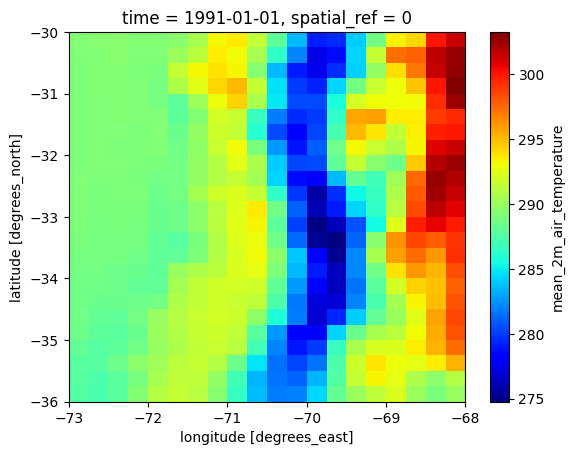

In [61]:
#Grafico el raster de temperaturas para la fecha seleccionada
ax=da.plot(x='lon',y='lat',cmap='jet')
plt.show()